# 1. Setup and Data Loading

In [2]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add src to path for modular imports (optional, if you set up the src folder)

In [3]:
sys.path.append(os.path.abspath('../src'))

# Set plot style

In [4]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load Data

In [8]:
try:
    df = pd.read_csv(
        '../data/insurance_claims.csv',
        sep='|',            # pipe-separated
        engine='python',    # safer for messy files
        on_bad_lines='skip' # skip malformed rows
    )
    print("Data Loaded Successfully")
    print(f"Dataset Shape: {df.shape}")
except FileNotFoundError:
    print("Error: File not found. Please check the data path.")

Data Loaded Successfully
Dataset Shape: (1000098, 52)


# Check initial structure

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   UnderwrittenCoverID       1000098 non-null  int64  
 1   PolicyID                  1000098 non-null  int64  
 2   TransactionMonth          1000098 non-null  object 
 3   IsVATRegistered           1000098 non-null  bool   
 4   Citizenship               1000098 non-null  object 
 5   LegalType                 1000098 non-null  object 
 6   Title                     1000098 non-null  object 
 7   Language                  1000098 non-null  object 
 8   Bank                      854137 non-null   object 
 9   AccountType               959866 non-null   object 
 10  MaritalStatus             991839 non-null   object 
 11  Gender                    990562 non-null   object 
 12  Country                   1000098 non-null  object 
 13  Province                  1

# Example numeric columns (adjust based on your CSV)

In [11]:
num_cols = ['TotalPremium', 'TotalClaims', 'SumInsured', 'CalculatedPremiumPerTerm']

for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Convert Dates
if 'TransactionMonth' in df.columns:
    df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'], errors='coerce')

# Missing Values Check

In [12]:
missing = df.isnull().sum()
print("\nMissing Values (Top 10):")
print(missing[missing > 0].head(10))


Missing Values (Top 10):
Bank             145961
AccountType       40232
MaritalStatus      8259
Gender             9536
mmcode              552
VehicleType         552
make                552
Model               552
Cylinders           552
cubiccapacity       552
dtype: int64


# 3. Feature Engineering
# Creating KPIs:
# 1. Loss Ratio = TotalClaims / TotalPremium
# 2. Margin = TotalPremium - TotalClaims

In [14]:
df['Margin'] = df['TotalPremium'] - df['TotalClaims']
df['LossRatio'] = df['TotalClaims'] / df['TotalPremium']
df['LossRatio'] = df['LossRatio'].replace([np.inf, -np.inf], 0).fillna(0)

print(df[['TotalPremium', 'TotalClaims', 'Margin', 'LossRatio']].describe())

       TotalPremium   TotalClaims        Margin     LossRatio
count  1.000098e+06  1.000098e+06  1.000098e+06  1.000098e+06
mean   6.190550e+01  6.486119e+01 -2.955694e+00  2.163699e-01
std    2.302845e+02  2.384075e+03  2.367137e+03  7.304735e+00
min   -7.825768e+02 -1.200241e+04 -3.928486e+05 -1.870012e+01
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
50%    2.178333e+00  0.000000e+00  2.157687e+00  0.000000e+00
75%    2.192982e+01  0.000000e+00  2.192982e+01  0.000000e+00
max    6.528260e+04  3.930921e+05  6.528260e+04  2.553600e+03


# 4. Univariate Analysis

# Premium Distribution

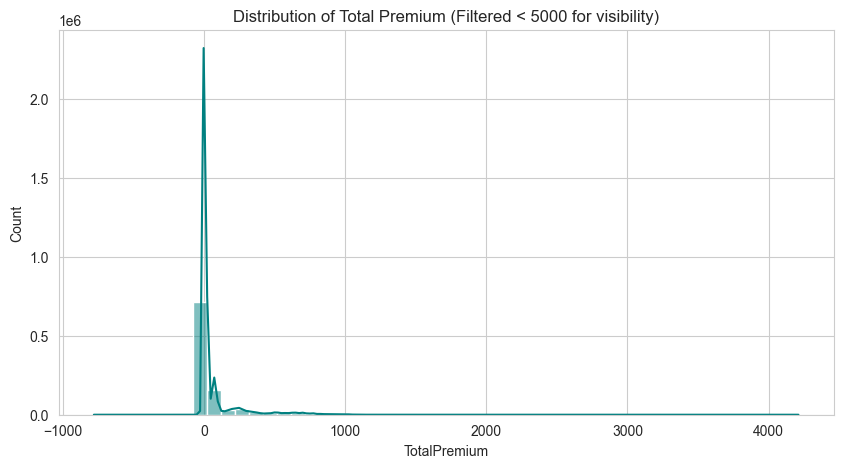

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(df[df['TotalPremium'] < 5000]['TotalPremium'], bins=50, color='teal', kde=True)
plt.title('Distribution of Total Premium (Filtered < 5000 for visibility)')
plt.show()

# Claims Distribution

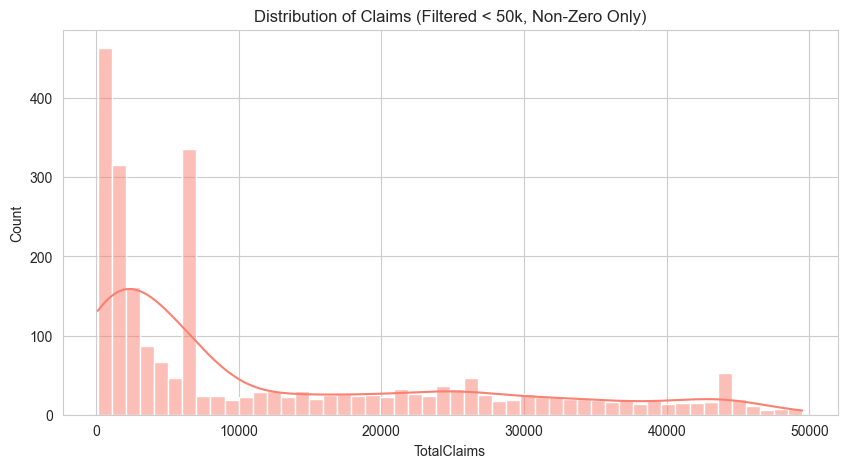

In [16]:
plt.figure(figsize=(10, 5))
claims_only = df[df['TotalClaims'] > 0]
sns.histplot(claims_only[claims_only['TotalClaims'] < 50000]['TotalClaims'], bins=50, color='salmon', kde=True)
plt.title('Distribution of Claims (Filtered < 50k, Non-Zero Only)')
plt.show()

# 5. Bivariate Analysis
# Loss Ratio by Province

C:\Users\mulat\AppData\Local\Temp\ipykernel_18536\4218168501.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=prov_risk, x='Province', y='LossRatio', palette='viridis')


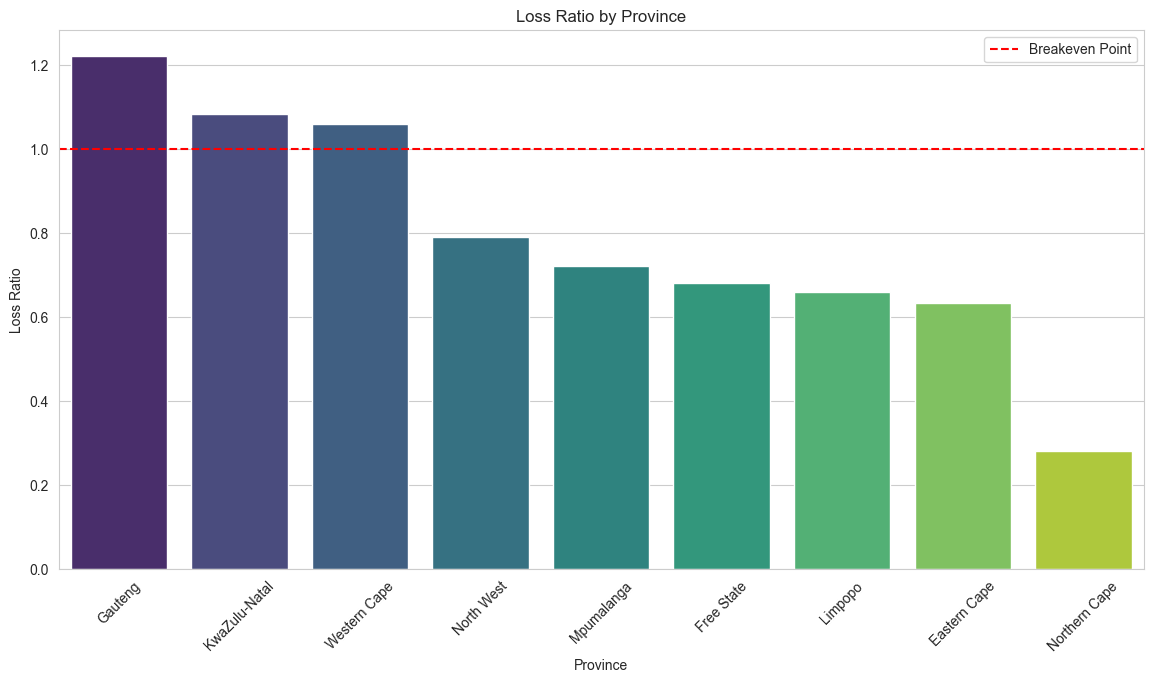

In [17]:
if 'Province' in df.columns:
    prov_risk = df.groupby('Province')[['TotalClaims', 'TotalPremium']].sum().reset_index()
    prov_risk['LossRatio'] = prov_risk['TotalClaims'] / prov_risk['TotalPremium']
    prov_risk = prov_risk.sort_values('LossRatio', ascending=False)

    plt.figure(figsize=(14, 7))
    sns.barplot(data=prov_risk, x='Province', y='LossRatio', palette='viridis')
    plt.title('Loss Ratio by Province')
    plt.xticks(rotation=45)
    plt.ylabel('Loss Ratio')
    plt.axhline(y=1.0, color='r', linestyle='--', label='Breakeven Point')
    plt.legend()
    plt.show()

# Correlation Analysis

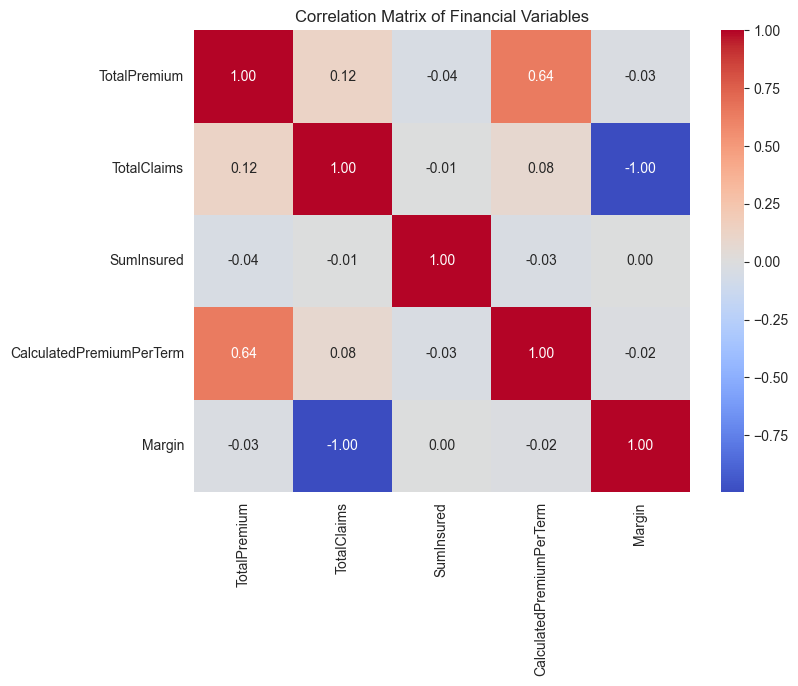

In [18]:
corr_cols = ['TotalPremium', 'TotalClaims', 'SumInsured', 'CalculatedPremiumPerTerm', 'Margin']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Financial Variables')
plt.show()

# Scatter plot (sampled)

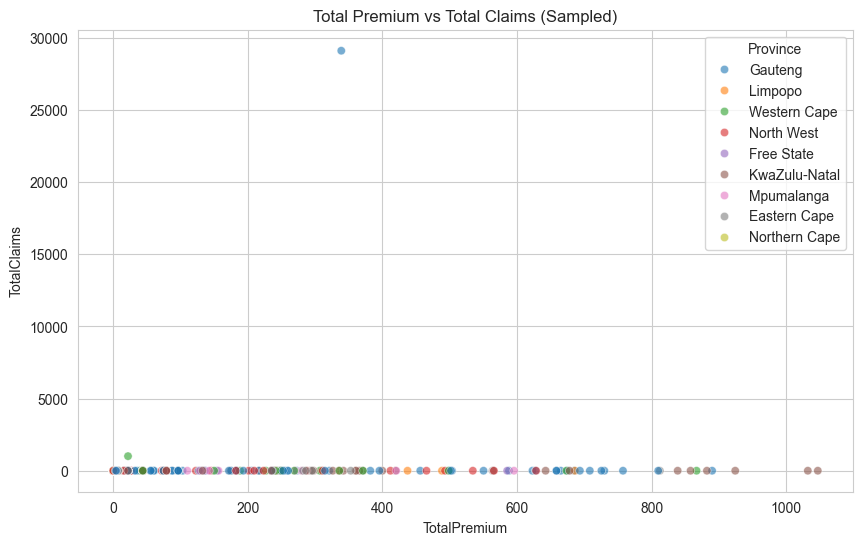

In [19]:
sample_df = df.sample(n=min(1000, len(df)), random_state=42)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_df, x='TotalPremium', y='TotalClaims', hue='Province', alpha=0.6)
plt.title('Total Premium vs Total Claims (Sampled)')
plt.show()

# 6. Outlier Detection

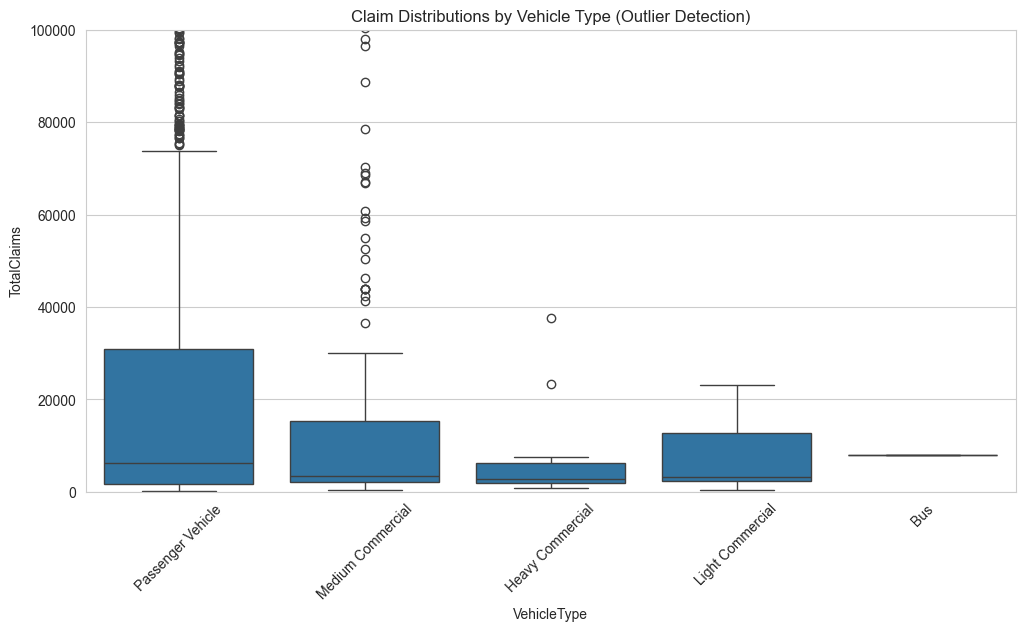

In [20]:
if 'VehicleType' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='VehicleType', y='TotalClaims', data=df[df['TotalClaims'] > 0])
    plt.xticks(rotation=45)
    plt.ylim(0, 100000)
    plt.title('Claim Distributions by Vehicle Type (Outlier Detection)')
    plt.show()